In [54]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
HUES = {}
# HUES["GCN-Transformer"] = "Red"
# HUES["GCN-Avg"] = "Purple"
# HUES["GCN"] = "Black"
# #HUES["DBMS (instance-tuned)"] = "Gray"

# HUES["DBMS-all"] = "Gray"


# HUES["GCN-Pretrained-Latent"] = "Blue"
# HUES["GCN-Pretrained"] = "Green"
# HUES["GCN-PretrainedT-CurrentDB"] = "Gray"
# HUES["GCN-PretrainedT-NoCurrentDB"] = "Green"
# HUES["GCN-PreatinedT-NoCurrentDB-NoActualFeats"] = "Black"


BASELINES = ["DBMS (TestEnv)", "DBMS (TestDB + TestEnv)"]

HUES["DBMS (TestEnv)"] = "Red"
HUES["DBMS (TestDB + TestEnv)"] = "Violet"

#HUES["Pretrained Environment Transformer"] = "Green"

HUES["GCN (TestDB)"] = "Black"
HUES["GCN + LPT"] = "Green"
HUES["GCN (TestDB + TestEnv)"] = "Purple"
HUES["GCN-Transformer (TestDB)"] = "Gray"

In [56]:
api = wandb.Api()

In [57]:
bruns = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"config.alg": "dbms"},
      {"$or": [
            {"$and": [
                {"tags":"single-final9-min-01-baseline"},
                #{"tags":"single-stack-final9-min-01-baseline"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(bruns)} runs")

Found 3 runs


In [58]:
import time
start = time.time()

bdfs = []

cur_run = None
for run in bruns:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        print("not finished!")
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    bdfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(bdfs))

bdf = pd.concat(bdfs)
#bdf = bdf[bdf["config"] == "configs/baselines/config_dbms_imdb.yaml"]
print(len(bdf))

took:  0.012414932250976562
3
3


In [59]:
bdf[["Final-LatencyQError-test-mean", "Final-LatencyQError-test_unseen-mean", "dbms_fit_test"]]

,Final-LatencyQError-test-mean,Final-LatencyQError-test_unseen-mean,dbms_fit_test
0,18.042923,26.897645,0
0,18.042923,NaN,0
0,20.202283,17.142025,1


In [81]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      #{"config.eval_epoch": 5},
      #{"config.traindata_dir": "LatencyCollectorResults/background"},
      #{"config.traindata_dir": "LatencyCollectorResults/new"},
      {"$or": [
            {"$or": [
                {"tags":"imdb-ablation-data1"},
                {"tags":"imdb-final9-ablations"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 181 runs


In [82]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  1.5356559753417969
151


In [83]:
df = pd.concat(dfs)

df1 = df[df["config"].str.contains("transfer")]
df1 = df[df["feat_onehot"] == 0]
print("Num transferrable: ", len(df1))

df2 = df[(df["tags"] == "exp1_single,exp2_single,exp3_single,exp7_single_ceb2") &
            (df["split_kind"] == "lt_type-query") &
            ~(df["config"].str.contains("nopretrain"))
        ]

df3 = df[df["config"].str.contains("nopretrain")]
df3 = df3[df3["sys_net_pretrained"] == 0]

# df4 = df[(df["split_kind"] == "lt_type-query") & \
#           ~(df["config"].str.contains("nopretrain"))
#         ]

print(set(df3["seed"]))
df3 = df3.drop_duplicates(["seed"])
print(len(df3))

df = pd.concat([df1,df2, df3])

df = pd.concat([df, bdf])
print(len(df))

Num transferrable:  0
set()
0
72


In [84]:
df4[["Final-LatencyQError-test-mean"]]

,Final-LatencyQError-test-mean
0,10.322130
0,6.128253
0,5.939919
0,8.076721
0,7.277240
0,7.546700
0,8.300476
0,6.085395
0,4.713240
0,8.611140


In [85]:
set(df["alg"])

{'dbms', 'nn'}

In [86]:
# GCN, GCN-Transformer, GCN-Pretrained, GCN-Pretrained-Latent

PRETRAINED_NAME = False

def get_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS\n(Test DB,Test Env)"
        else:
            return "DBMS\n(Diff DB,Test Env)"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                return "GCN\n(Diff DB,Test Env)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                return "GCN\n(Test DB,Diff Env)"
            else:
                return "GCN\n(Test DB,Test Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models4/concurrent_noimdb_randomsplit_test90.wt":
                return "Factorized (LPT)"
            elif row["sys_net_pretrained_fn"] == "models5/mixed_nostack_logfeats_cols.wt":
                return "Factorized (LPT)"
            else:
                return row["sys_net_pretrained_fn"]
    else:
        return None
    
def get_final_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS\n(Test DB,Test Env)"
        else:
            return "DBMS\n(Diff DB,Test Env)"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                return "GCN\n(Diff DB,Test Env)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                return "GCN\n(Test DB,Diff Env)"
            else:
                return "GCN\n(Test DB,Test Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models4/concurrent_noimdb_randomsplit_test90.wt":
                return "Factorized (LPT)"
            elif row["sys_net_pretrained_fn"] == "models5/mixed_nostack_logfeats_cols.wt":
                return "Factorized (LPT)"
            else:
                return row["sys_net_pretrained_fn"]
    else:
        return None

def get_workload(row):
    if "dbms" in row["alg"].lower():
        return "IMDb"
    
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
    
    
df["Estimator"] = df.apply(lambda x: get_final_alg(x),axis=1)
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

In [87]:
df = df[df["alg"].notna()]

In [88]:
print(len(df))
print(set(df["Estimator"]))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print("pretrain: " , set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))
print(set(df["tags"]))
print(set(df["seed"]))
print(df.keys())

72
{'models4/ablation_numinst_6.wt', 'models4/ablation_numinst_6_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt', 'models4/ablation_numinst_8.wt', 'DBMS\n(Test DB,Test Env)', 'models4/ablation_numinst_2.wt', 'Factorized (LPT)', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/concurrent_noimdb_logfeats_col_test05.wt', 'DBMS\n(Diff DB,Test Env)', 'models4/ablation_numinst_4.wt', 'models4/ablation_numinst_8_s_{2}.wt', 'models4/ablation_numinst_2_s_{2}.wt', 'models4/ablation_numinst_4_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test099.wt', 'models4/ablation_numinst_1.wt', 'models4/concurrent_noimdb_randomsplit_test99.wt'}
{1}
{0, 1, 2, 3, 4}
{'configs/baselines/config_dbms_imdb.yaml', 'configs/evals/single/config_noimdb_cols.yaml'}
pretrain:  {'models4/ablation_numinst_6.wt', 'models4/ablation_numinst_6_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt', 'models4/ablation_numinst_8.wt', 'models4/noactual_mixed_noimdb_logfeats_col.wt', 

In [89]:
#df = df[df["alg"] != "DBMS-all"]
#df = df[df["alg"] != "GCN-Pretrained-Latent"]

In [90]:
print(set(df["sys_net_pretrained_fn"]))
#print(set(df["Tag"]))

{'models4/ablation_numinst_6.wt', 'models4/ablation_numinst_6_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt', 'models4/ablation_numinst_8.wt', 'models4/noactual_mixed_noimdb_logfeats_col.wt', 'models4/ablation_numinst_2.wt', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/concurrent_noimdb_logfeats_col_test05.wt', 'models4/concurrent_noimdb_randomsplit_test90.wt', 'models4/ablation_numinst_4.wt', None, 'models4/ablation_numinst_8_s_{2}.wt', 'models4/ablation_numinst_2_s_{2}.wt', 'models4/ablation_numinst_4_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test099.wt', 'models4/ablation_numinst_1.wt', 'models4/concurrent_noimdb_randomsplit_test99.wt'}


In [91]:
#df = df[df["weight_decay"] == 0.1]

In [92]:
pd.set_option('display.max_rows', 500)

tmp = df[df["num_instances"] == 1]
tmp[["seed", "num_instances", "alg", "extra_training", "weight_decay", "lr", "Final-LatencyQError-test-mean", "Final-LatencyAE-test-mean" , "weight_decay", "Final-LatencyMSE-test-mean", 
    "Final-LatencyQError-test-median", "Final-LatencyQError-test-99p"]].sort_values(by="seed")

,seed,num_instances,alg,extra_training,weight_decay,lr,Final-LatencyQError-test-mean,Final-LatencyAE-test-mean,weight_decay,Final-LatencyMSE-test-mean,Final-LatencyQError-test-median,Final-LatencyQError-test-99p
0,0,1,models4/concurrent_noimdb_logfeats_col_single-...,0,1,0.0001,10.080331,98.643333,1,39217.691956,3.660086,95.717359
0,0,1,Factorized (LPT),0,1,0.0001,5.410773,55.230169,1,15103.513613,2.391230,46.336498
0,0,1,models4/concurrent_noimdb_logfeats_col_test09.wt,0,1,0.0001,5.239281,56.594548,1,16161.163358,2.487278,43.687667
0,0,1,models4/concurrent_noimdb_randomsplit_test99.wt,0,1,0.0001,5.902248,59.935610,1,17041.225542,2.612083,49.157034
0,0,1,models4/concurrent_noimdb_logfeats_col_test05.wt,0,1,0.0001,6.413125,74.529166,1,25929.943062,2.677879,56.505228
0,0,1,Factorized (LPT),0,1,0.0001,4.959790,51.506838,1,13027.640699,2.448435,34.458387
0,0,1,models4/concurrent_noimdb_logfeats_col_test099.wt,0,1,0.0001,5.387868,55.622836,1,15685.119407,2.526996,43.142443
0,1,1,models4/ablation_numinst_2.wt,0,1,0.0001,16.920848,106.295675,1,35757.769635,4.507705,201.250808
0,1,1,Factorized (LPT),0,1,0.0001,6.427200,60.133568,1,16028.878942,2.801277,57.139706
0,1,1,models4/ablation_numinst_4.wt,0,1,0.0001,9.946020,92.686784,1,35797.047812,3.194784,109.332953


In [93]:
print(set(df["alg"]))
print(set(df["Estimator"]))

{'models4/ablation_numinst_6.wt', 'models4/ablation_numinst_6_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt', 'models4/ablation_numinst_8.wt', 'DBMS\n(Test DB,Test Env)', 'models4/ablation_numinst_2.wt', 'Factorized (LPT)', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/concurrent_noimdb_logfeats_col_test05.wt', 'DBMS\n(Diff DB,Test Env)', 'models4/ablation_numinst_4.wt', 'models4/ablation_numinst_8_s_{2}.wt', 'models4/ablation_numinst_2_s_{2}.wt', 'models4/ablation_numinst_4_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test099.wt', 'models4/ablation_numinst_1.wt', 'models4/concurrent_noimdb_randomsplit_test99.wt'}
{'models4/ablation_numinst_6.wt', 'models4/ablation_numinst_6_s_{2}.wt', 'models4/concurrent_noimdb_logfeats_col_test09.wt', 'models4/ablation_numinst_8.wt', 'DBMS\n(Test DB,Test Env)', 'models4/ablation_numinst_2.wt', 'Factorized (LPT)', 'models4/concurrent_noimdb_logfeats_col_single-instance.wt', 'models4/concurrent_noimdb_logfea

In [94]:
#df = df[df["seed"] < 4]

In [95]:
single_df = df[~df["config"].str.contains("mt")]
single_df_imdb = single_df[single_df["config"].str.contains("noimdb")]
#tmp2 = df[df["config"].str.contains("mt")]
single_df_stack = single_df[single_df["config"].str.contains("nostack")]

In [96]:
single_df_imdb.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="mean")

,Estimator,count,mean,std,min,25%,50%,75%,max
13,models4/concurrent_noimdb_logfeats_col_test09.wt,4.0,6.235161,0.511418,5.587039,6.044623,6.261322,6.451860,6.830962
12,models4/concurrent_noimdb_logfeats_col_test05.wt,4.0,6.495519,1.277428,5.304435,5.456755,6.420555,7.459319,7.836531
1,Factorized (LPT),10.0,6.755366,0.868139,5.773417,6.273267,6.603193,7.161102,8.692348
7,models4/ablation_numinst_6.wt,4.0,6.885633,0.514669,6.439645,6.652908,6.737342,6.970068,7.628204
8,models4/ablation_numinst_6_s_{2}.wt,4.0,6.957694,1.492319,5.656268,5.800848,6.679164,7.836011,8.816179
10,models4/ablation_numinst_8_s_{2}.wt,4.0,7.124382,2.147731,4.893874,6.016556,6.797545,7.905371,10.008567
9,models4/ablation_numinst_8.wt,4.0,7.237139,2.105790,5.391899,5.838596,6.720138,8.118681,10.116380
5,models4/ablation_numinst_4.wt,4.0,7.388426,3.811179,5.127489,5.129318,5.687934,7.947042,13.050345
15,models4/concurrent_noimdb_randomsplit_test99.wt,5.0,7.434568,1.391300,5.914445,6.723296,6.746562,8.584924,9.203611
6,models4/ablation_numinst_4_s_{2}.wt,4.0,9.321197,3.511458,6.964089,7.092977,7.934861,10.163081,14.450978


In [97]:
# Function to extract number of pre-training instances
def extract_num_instances(name):
    if name == "Factorized (LPT)":
        return 10
    elif "numinst" not in name:
        return None
    
    parts = name.split('numinst_')
    if len(parts) > 1:
        num_part = parts[1]
        # Extract the number before the first non-numeric character
        num = ''.join(filter(str.isdigit, num_part.split('_')[0]))
        return int(num) if num.isdigit() else None
    return None

# Apply the function to create a new column
single_df_imdb['Num Pre-training instance types'] = single_df_imdb['Estimator'].apply(extract_num_instances)


In [100]:
single_df_imdb.groupby(["Num Pre-training instance types"])["Final-LatencyQError-test_unseen-mean"].describe().reset_index().sort_values(by="Num Pre-training instance types")

,Num Pre-training instance types,count,mean,std,min,25%,50%,75%,max
0,1.0,4.0,19.625449,14.705068,10.261060,10.813338,13.438522,22.250633,41.363693
1,2.0,8.0,13.284239,6.909166,6.335071,8.901470,10.050483,18.039637,24.351935
2,4.0,8.0,8.354811,3.546376,5.127489,5.966938,7.050014,9.812923,14.450978
3,6.0,8.0,6.921664,1.034138,5.656268,6.291994,6.737342,7.539017,8.816179
4,8.0,8.0,7.180761,1.970015,4.893874,5.838596,6.797545,8.091727,10.116380
5,10.0,10.0,6.755366,0.868139,5.773417,6.273267,6.603193,7.161102,8.692348


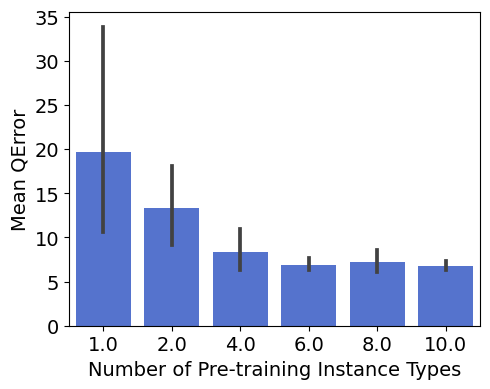

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the figure size (adjust as needed for your LaTeX document)
plt.figure(figsize=(5, 4))  # Width, Height in inches

# Create the barplot
barplot = sns.barplot(
    data=single_df_imdb, 
    y="Final-LatencyQError-test_unseen-mean", 
    x="Num Pre-training instance types",
    color="royalblue"
)

# Set label sizes
plt.xlabel('Number of Pre-training Instance Types', fontsize=14)
plt.ylabel('Mean QError', fontsize=14)

# Set title and its size
#plt.title('IMDb', fontsize=14)

# Set tick sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Optionally, add gridlines for better readability
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Save the plot as a high-resolution image for inclusion in LaTeX
plt.savefig('num_instances_ablation.pdf', bbox_inches="tight")

plt.show()
